In [1]:
# Importing dependecies
import pandas as pd
import json
import requests
import prettytable
from config import api_key
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Dictionary of series ID 
category_dict = {
    'CXUFOODAWAYLB1101M': 'Food Away',
    'CXUAPPARELLB1101M': 'Apparel',
    'CXUENTRTAINLB1101M': 'Entertainment',
    'CXUCASHCONTLB1101M': 'Cash Contribution',
    'CXUALCBEVGLB1101M': 'Alcohol Beverages',
    'CXUEDUCATNLB1101M': 'Education',
    'CXUPERSCARELB1101M': 'Personal Care',
    'CXUTOBACCOLB1101M': 'Tobacco'
}

# List of series IDs
category_list = list(category_dict.keys())

In [3]:
# Load the json response for the API queries
def json_df(dictionary):
    headers = {'Content-type': 'application/json'}
    data = json.dumps({"seriesid": list(dictionary.keys()),"startyear":"2005", "endyear":"2018","registrationkey":api_key})
    p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
    json_data = json.loads(p.text)

    try:
        df = pd.DataFrame()

        # Loops through the json response to create a DataFrame
        for series in json_data['Results']['series']:
            # Create an initial DataFrame with column of Series IDs and dictionary of data
            df_initial = pd.DataFrame(series)
            series_col = df_initial['seriesID'][0]

            # Loops through the length of the initial DF to split up its second column
            for i in range(0, len(df_initial) - 1):
                df_row = pd.DataFrame(df_initial['data'][i])
                df_row['seriesID'] = series_col
                if 'code' not in str(df_row['footnotes']): 
                    df_row['footnotes'] = ''
                else:
                    df_row['footnotes'] = str(df_row['footnotes']).split("'code': '",1)[1][:1]
                df = df.append(df_row, ignore_index=True)

    except:
        json_data['status'] == 'REQUEST_NOT_PROCESSED'
        print('BLS API has given the following Response:', json_data['status'])
        print('Reason:', json_data['message'])
    return df

In [4]:
def get_total(df):
    # Initialize variables
    total = []
    dict_list = []
    i = 0
    
    # Convert the value column to float - a numeric data type will be needed to visualize the data
    df['value'] = df['value'].astype(float)
    
    series_set = set(df["seriesID"])
    for e in series_set:
        dict_list.append(e)
    
    dict_list = sorted(dict_list)
    
    # Loop through series list to create a list of the totals of each spending category
    for key in dict_list:
        # Append a value to a list to record the spending for each category
        total.append(int(df.groupby('seriesID')['value'].sum()[key]))

        # Counter
        i = i + 1
    return total

In [5]:
df_category = json_df(category_dict)

In [6]:
total = get_total(df_category)

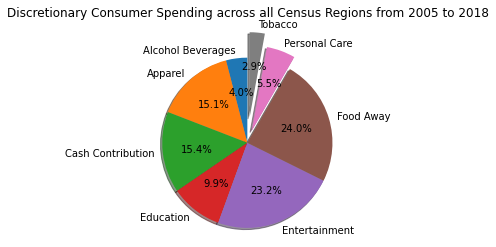

In [7]:
# Labels of the categories
labels = sorted(list(category_dict.values()))

# Explode the two smallest expenses (i.e Tobacco and Personal Care)
explode = (0, 0, 0, 0, 0, 0, .15, .3)  

# Initialize figure and axis
fig1, ax1 = plt.subplots()

# Create pie chart of the breakdown of discretionary spending
ax1.pie(total, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Discretionary Consumer Spending across all Census Regions from 2005 to 2018')
plt.xlabel('')
plt.ylabel('')
plt.show()

In [8]:
df_category = df_category.sort_values(['seriesID','year'], ascending = True).reset_index(drop=True)
df_category

,year,period,periodName,latest,value,footnotes,seriesID
0,2006,A01,Annual,NaN,497.0,,CXUALCBEVGLB1101M
1,2007,A01,Annual,NaN,457.0,,CXUALCBEVGLB1101M
2,2008,A01,Annual,NaN,444.0,,CXUALCBEVGLB1101M
3,2009,A01,Annual,NaN,435.0,,CXUALCBEVGLB1101M
4,2010,A01,Annual,NaN,412.0,,CXUALCBEVGLB1101M
...,...,...,...,...,...,...,...
99,2014,A01,Annual,NaN,319.0,,CXUTOBACCOLB1101M
100,2015,A01,Annual,NaN,349.0,,CXUTOBACCOLB1101M
101,2016,A01,Annual,NaN,337.0,,CXUTOBACCOLB1101M
102,2017,A01,Annual,NaN,332.0,,CXUTOBACCOLB1101M


In [9]:
# Get percent change over the years, grouped by series ID
df_category['pct_decimal'] = df_category.groupby(['seriesID'])['value'].pct_change()
df_category['percent_change'] = df_category['pct_decimal'].multiply(100)
df_category

,year,period,periodName,latest,value,footnotes,seriesID,pct_decimal,percent_change
0,2006,A01,Annual,NaN,497.0,,CXUALCBEVGLB1101M,NaN,NaN
1,2007,A01,Annual,NaN,457.0,,CXUALCBEVGLB1101M,-0.080483,-8.048290
2,2008,A01,Annual,NaN,444.0,,CXUALCBEVGLB1101M,-0.028446,-2.844639
3,2009,A01,Annual,NaN,435.0,,CXUALCBEVGLB1101M,-0.020270,-2.027027
4,2010,A01,Annual,NaN,412.0,,CXUALCBEVGLB1101M,-0.052874,-5.287356
...,...,...,...,...,...,...,...,...,...
99,2014,A01,Annual,NaN,319.0,,CXUTOBACCOLB1101M,-0.033333,-3.333333
100,2015,A01,Annual,NaN,349.0,,CXUTOBACCOLB1101M,0.094044,9.404389
101,2016,A01,Annual,NaN,337.0,,CXUTOBACCOLB1101M,-0.034384,-3.438395
102,2017,A01,Annual,NaN,332.0,,CXUTOBACCOLB1101M,-0.014837,-1.483680


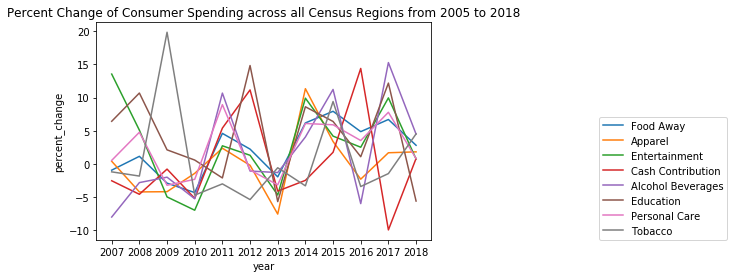

In [10]:
# Produce line chart of percentage change of spend on each item over time
labels = (list(category_dict.values()))
i=0
fig,ax = plt.subplots()
for seriesID in list(category_dict.keys()):
    ax.plot(df_category[df_category.seriesID==seriesID].year,
            df_category[df_category.seriesID==seriesID].percent_change,
            label=labels[i])
    i=i+1
plt.title('Percent Change of Consumer Spending across all Census Regions from 2005 to 2018')
ax.set_xlabel("year")
ax.set_ylabel("percent_change")
plt.legend(loc=(1.5,0))

In [ ]:
age_dict = {
    
#AGE UNDER 25 LB0402M
    #STUFF FOR DISCRECTIONARY (FREELY SPENT)
    'CXUFOODAWAYLB0402M': 'FoodAway_AllRegions',
    'CXUAPPARELLB0402M': 'Apparel_AllRegions',
    'CXUENTRTAINLB0402M': 'Entertainment_AllRegions',
    'CXUCASHCONTLB0402M': 'CashCont_AllRegions',
    'CXUALCBEVGLB0402M': 'Alcohol_AllRegions',
    'CXUEDUCATNLB0402M': 'Edu_AllRegions',
    'CXUPERSCARELB0402M': 'PersonalCare_AllRegions',
    'CXUTOBACCOLB0402M': 'Tobacco_AllRegions',
    #STUFF FOR DISPOSABLE (BILLS TO PAY)
    'CXUFOODHOMELB0402M': 'FOOD HOME',
    'CXUHEALTHLB0402M': 'HEALTH',
    'CXUHOUSINGLB0402M': 'HOUSING',
    'CXUTRANSLB0402M': 'TRANSPORT',  
    
#Age 25-34 LB0403M
    #STUFF FOR DISCRECTIONARY (FREELY SPENT)
    'CXUFOODAWAYLB0403M': 'FoodAway_AllRegions',
    'CXUAPPARELLB0403M': 'Apparel_AllRegions',
    'CXUENTRTAINLB0403M': 'Entertainment_AllRegions',
    'CXUCASHCONTLB0403M': 'CashCont_AllRegions',
    'CXUALCBEVGLB0403M': 'Alcohol_AllRegions',
    'CXUEDUCATNLB0403M': 'Edu_AllRegions',
    'CXUPERSCARELB0403M': 'PersonalCare_AllRegions',
    'CXUTOBACCOLB0403M': 'Tobacco_AllRegions',
    #STUFF FOR DISPOSABLE (BILLS TO PAY)
    'CXUFOODHOMELB0403M': 'FOOD HOME',
    'CXUHEALTHLB0403M': 'HEALTH',
    'CXUHOUSINGLB0403M': 'HOUSING',
    'CXUTRANSLB0403M': 'TRANSPORT',   
    
#Age 35-44 LB0404M
    #STUFF FOR DISCRECTIONARY (FREELY SPENT)
    'CXUFOODAWAYLB0404M': 'FoodAway_AllRegions',
    'CXUAPPARELLB0404M': 'Apparel_AllRegions',
    'CXUENTRTAINLB0404M': 'Entertainment_AllRegions',
    'CXUCASHCONTLB0404M': 'CashCont_AllRegions',
    'CXUALCBEVGLB0404M': 'Alcohol_AllRegions',
    'CXUEDUCATNLB0404M': 'Edu_AllRegions',
    'CXUPERSCARELB0404M': 'PersonalCare_AllRegions',
    'CXUTOBACCOLB0404M': 'Tobacco_AllRegions',
    #STUFF FOR DISPOSABLE (BILLS TO PAY)
    'CXUFOODHOMELB0404M': 'FOOD HOME',
    'CXUHEALTHLB0404M': 'HEALTH',
    'CXUHOUSINGLB0404M': 'HOUSING',
    'CXUTRANSLB0404M': 'TRANSPORT',   
    
#Age 45-54 LB0405M
    #STUFF FOR DISCRECTIONARY (FREELY SPENT)
    'CXUFOODAWAYLB0405M': 'FoodAway_AllRegions',
    'CXUAPPARELLB0405M': 'Apparel_AllRegions',
    'CXUENTRTAINLB0405M': 'Entertainment_AllRegions',
    'CXUCASHCONTLB0405M': 'CashCont_AllRegions',
    'CXUALCBEVGLB0405M': 'Alcohol_AllRegions',
    'CXUEDUCATNLB0405M': 'Edu_AllRegions',
    'CXUPERSCARELB0405M': 'PersonalCare_AllRegions',
    'CXUTOBACCOLB0405M': 'Tobacco_AllRegions',
    #STUFF FOR DISPOSABLE (BILLS TO PAY)
    'CXUFOODHOMELB0405M': 'FOOD HOME',
    'CXUHEALTHLB0405M': 'HEALTH',
    'CXUHOUSINGLB0405M': 'HOUSING',
    'CXUTRANSLB0405M': 'TRANSPORT',   
    
#Age 55-64 LB0406M
    #STUFF FOR DISCRECTIONARY (FREELY SPENT)
    'CXUFOODAWAYLB0406M': 'FoodAway_AllRegions',
    'CXUAPPARELLB0406M': 'Apparel_AllRegions',
    'CXUENTRTAINLB0406M': 'Entertainment_AllRegions',
    'CXUCASHCONTLB0406M': 'CashCont_AllRegions',
    'CXUALCBEVGLB0406M': 'Alcohol_AllRegions',
    'CXUEDUCATNLB0406M': 'Edu_AllRegions',
    'CXUPERSCARELB0406M': 'PersonalCare_AllRegions',
    'CXUTOBACCOLB0406MM': 'Tobacco_AllRegions',
    #STUFF FOR DISPOSABLE (BILLS TO PAY)
    'CXUFOODHOMELB0406MM': 'FOOD HOME',
    'CXUHEALTHLB0406MM': 'HEALTH',
    'CXUHOUSINGLB0406MM': 'HOUSING',
    'CXUTRANSLB0406MM': 'TRANSPORT',  
    
#Age Over 65 LB0407
    #STUFF FOR DISCRECTIONARY (FREELY SPENT)
    'CXUFOODAWAYLB0407M': 'FoodAway_AllRegions',
    'CXUAPPARELLB0407M': 'Apparel_AllRegions',
    'CXUENTRTAINLB0407M': 'Entertainment_AllRegions',
    'CXUCASHCONTLB0407M': 'CashCont_AllRegions',
    'CXUALCBEVGLB0407M': 'Alcohol_AllRegions',
    'CXUEDUCATNLB0407M': 'Edu_AllRegions',
    'CXUPERSCARELB0407M': 'PersonalCare_AllRegions',
    'CXUTOBACCOLB0407M': 'Tobacco_AllRegions',
    #STUFF FOR DISPOSABLE (BILLS TO PAY)
    'CXUFOODHOMELB0407M': 'FOOD HOME',
    'CXUHEALTHLB0407M': 'HEALTH',
    'CXUHOUSINGLB0407M': 'HOUSING',
    'CXUTRANSLB0407M': 'TRANSPORT',   
}

df_age = json_df(age_dict)
#df_age.dtypes
df_age['value'].astype(float)
df_age

In [ ]:
#Set List for Each Age Group

id4age25 = ['CXUFOODAWAYLB0402M','CXUAPPARELLB0402M','CXUENTRTAINLB0402M','CXUCASHCONTLB0402M','CXUALCBEVGLB0402M',
              'CXUEDUCATNLB0402M','CXUPERSCARELB0402M','CXUTOBACCOLB0402M', 'CXUFOODHOMELB0402M','CXUHEALTHLB0402M',
              'CXUHOUSINGLB0402M', 'CXUTRANSLB0402M'
           ]

id4age25to34 = ['CXUFOODAWAYLB0403M','CXUAPPARELLB0403M','CXUENTRTAINLB0403M','CXUCASHCONTLB0403M','CXUALCBEVGLB0403M',
              'CXUEDUCATNLB0403M','CXUPERSCARELB0403M','CXUTOBACCOLB0403M', 'CXUFOODHOMELB0403M','CXUHEALTHLB0403M',
              'CXUHOUSINGLB0403M', 'CXUTRANSLB0403M'
               ]

id4age35to44 = ['CXUFOODAWAYLB0402M','CXUAPPARELLB0402M','CXUENTRTAINLB0402M','CXUCASHCONTLB0402M','CXUALCBEVGLB040M',
              'CXUEDUCATNLB0402M','CXUPERSCARELB0402M','CXUTOBACCOLB0402M', 'CXUFOODHOMELB0402M','CXUHEALTHLB0402M',
              'CXUHOUSINGLB0402M', 'CXUTRANSLB0402M'
               ]

id4age45to54 = ['CXUFOODAWAYLB0405M','CXUAPPARELLB0405M','CXUENTRTAINLB0405M','CXUCASHCONTLB0405M','CXUALCBEVGLB0405M',
              'CXUEDUCATNLB0405M','CXUPERSCARELB0405M','CXUTOBACCOLB0405M', 'CXUFOODHOMELB0405M','CXUHEALTHLB0405M',
              'CXUHOUSINGLB0405M', 'CXUTRANSLB0405M'
               ]

id4age55to64 = ['CXUFOODAWAYLB0406M','CXUAPPARELLB0406M','CXUENTRTAINLB0406M','CXUCASHCONTLB0406M','CXUALCBEVGLB0406M',
              'CXUEDUCATNLB0406M','CXUPERSCARELB0406M','CXUTOBACCOLB0406M', 'CXUFOODHOMELB0406M','CXUHEALTHLB0406M',
              'CXUHOUSINGLB0406M', 'CXUTRANSLB0406M'
               ]

id4age65plus = ['CXUFOODAWAYLB0407M','CXUAPPARELLB0407M','CXUENTRTAINLB0407M','CXUCASHCONTLB0407M','CXUALCBEVGLB0407M',
              'CXUEDUCATNLB0407M','CXUPERSCARELB0407M','CXUTOBACCOLB0407M', 'CXUFOODHOMELB0407M','CXUHEALTHLB0407M',
              'CXUHOUSINGLB0407M', 'CXUTRANSLB0407M'
               ]

#Create Data Frames for Each Age Group

dfund25 = df_age[df_age["seriesID"].isin(id4age25)]
df2534 = df_age[df_age["seriesID"].isin(id4age25to34)]
df3544 = df_age[df_age["seriesID"].isin(id4age35to44)]
df4454 = df_age[df_age["seriesID"].isin(id4age45to54)]
df5564 = df_age[df_age["seriesID"].isin(id4age55to64)]
df65plus = df_age[df_age["seriesID"].isin(id4age65plus)]

#sum of all values across 2005-2018 relative to age group

#Under 25 Sums to Array
dfund25.dtypes
dfund25['value'].astype(float)

totfoodaway25 = dfund25.groupby('seriesID')['value'].sum()["CXUFOODAWAYLB0402M"]
totapp25 =  dfund25.groupby('seriesID')['value'].sum()["CXUAPPARELLB0402M"]
totent25 =  dfund25.groupby('seriesID')['value'].sum()["CXUENTRTAINLB0402M"]
totcashcont25 =  dfund25.groupby('seriesID')['value'].sum()["CXUCASHCONTLB0402M"]
totalc25 =  dfund25.groupby('seriesID')['value'].sum()["CXUALCBEVGLB0402M"]
totedu25 =  dfund25.groupby('seriesID')['value'].sum()["CXUEDUCATNLB0402M"]
totpersc25 =  dfund25.groupby('seriesID')['value'].sum()["CXUPERSCARELB0402M"]
tottob25 =  dfund25.groupby('seriesID')['value'].sum()["CXUTOBACCOLB0402M"]
totfoodhome25 =  dfund25.groupby('seriesID')['value'].sum()["CXUFOODHOMELB0402M"]
tothealth25 =  dfund25.groupby('seriesID')['value'].sum()["CXUHEALTHLB0402M"]
tothouse25 =  dfund25.groupby('seriesID')['value'].sum()["CXUHOUSINGLB0402M"]
tottrans25 =  dfund25.groupby('seriesID')['value'].sum()["CXUTRANSLB0402M"]

#Pass sums for each age group category to an array
